In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from BMAassumptions import BMA_final_classes

paired_diff_path = "/Users/neo/Documents/MODS/DeepHemeTransformer/DiffTransformerV1/dataprocessing/paired_diff.csv"
paired_diff_df = pd.read_csv(paired_diff_path)

GT_diff_vectors = []
Pipeline_diff_vectors = []

# Traverse all the rows in the dataframe
for index, row in tqdm(paired_diff_df.iterrows(), desc="Processing rows"):
    GT_diff_vector = []
    Pipeline_diff_vector = []
    for class_name in BMA_final_classes:
        GT_diff_vector.append(row[class_name + " (GT)"])
        Pipeline_diff_vector.append(row[class_name + " (Pipeline)"])

    # Convert row-wise vectors to numpy arrays and append to the main list
    GT_diff_vectors.append(np.array(GT_diff_vector))
    Pipeline_diff_vectors.append(np.array(Pipeline_diff_vector))

# Stack the row-wise vectors into a 2D array
stacked_GT_diff_vectors = np.stack(GT_diff_vectors)
stacked_Pipeline_diff_vectors = np.stack(Pipeline_diff_vectors)

print(stacked_GT_diff_vectors.shape)
print(stacked_Pipeline_diff_vectors.shape)

Processing rows: 352it [00:00, 13182.45it/s]

(352, 9)
(352, 9)


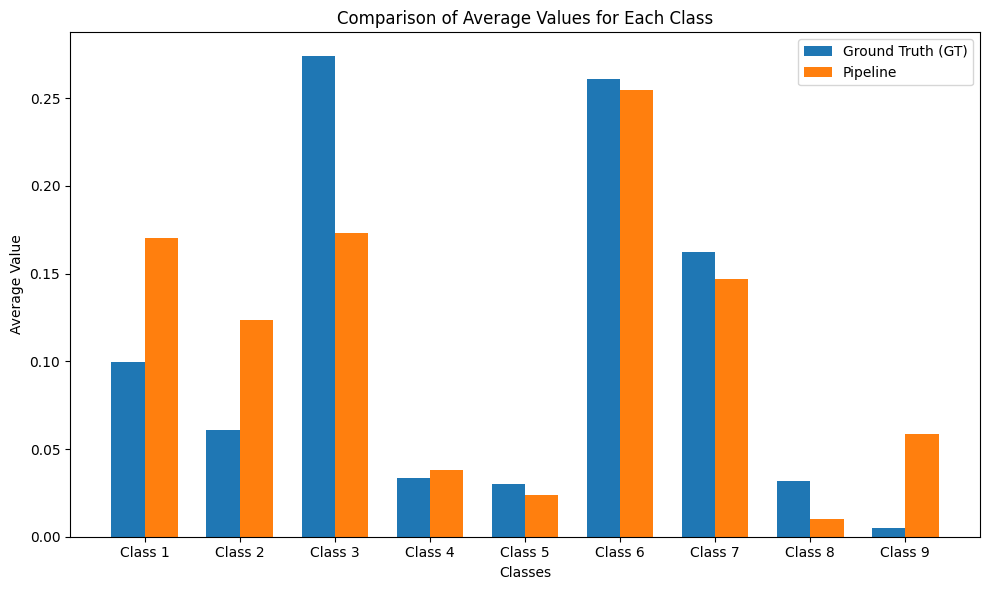

In [4]:
import matplotlib.pyplot as plt
# Compute the average of each feature (class) across the data points
avg_GT = np.mean(stacked_GT_diff_vectors, axis=0)
avg_Pipeline = np.mean(stacked_Pipeline_diff_vectors, axis=0)

# Generate the plot
x_labels = [f'Class {i+1}' for i in range(len(avg_GT))]
x = np.arange(len(x_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width/2, avg_GT, width, label='Ground Truth (GT)')
bar2 = ax.bar(x + width/2, avg_Pipeline, width, label='Pipeline')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Classes')
ax.set_ylabel('Average Value')
ax.set_title('Comparison of Average Values for Each Class')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

# Display the bar chart
plt.tight_layout()
plt.show()


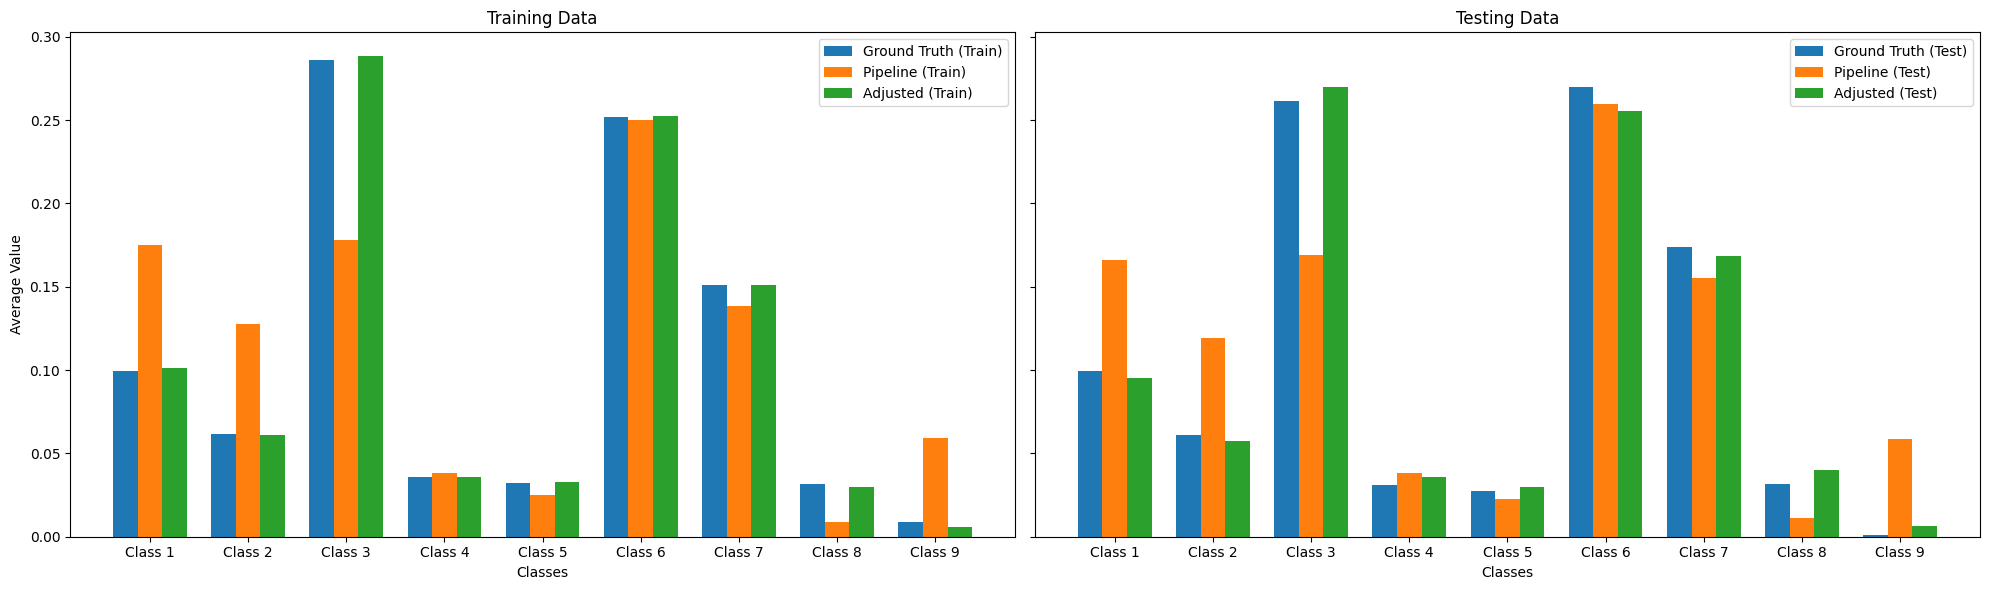

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Split the data into training and testing sets (50/50 split)
X_train, X_test, Y_train, Y_test = train_test_split(
    stacked_Pipeline_diff_vectors,
    stacked_GT_diff_vectors,
    test_size=0.5,
    random_state=42,
)

# Train the linear regression model on the training data
reg = LinearRegression()
reg.fit(X_train, Y_train)

# Predict adjusted values for both training and testing sets
adjusted_train = reg.predict(X_train)
adjusted_test = reg.predict(X_test)

# Compute the average values for each dataset
avg_GT_train = np.mean(Y_train, axis=0)
avg_Pipeline_train = np.mean(X_train, axis=0)
avg_Adjusted_train = np.mean(adjusted_train, axis=0)

avg_GT_test = np.mean(Y_test, axis=0)
avg_Pipeline_test = np.mean(X_test, axis=0)
avg_Adjusted_test = np.mean(adjusted_test, axis=0)

# Generate plots for both training and testing
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Training plot
x_labels = [f"Class {i+1}" for i in range(len(avg_GT_train))]
x = np.arange(len(x_labels))  # the label locations
width = 0.25  # the width of the bars

axes[0].bar(x - width, avg_GT_train, width, label="Ground Truth (Train)")
axes[0].bar(x, avg_Pipeline_train, width, label="Pipeline (Train)")
axes[0].bar(x + width, avg_Adjusted_train, width, label="Adjusted (Train)")
axes[0].set_title("Training Data")
axes[0].set_xlabel("Classes")
axes[0].set_ylabel("Average Value")
axes[0].set_xticks(x)
axes[0].set_xticklabels(x_labels)
axes[0].legend()

# Testing plot
axes[1].bar(x - width, avg_GT_test, width, label="Ground Truth (Test)")
axes[1].bar(x, avg_Pipeline_test, width, label="Pipeline (Test)")
axes[1].bar(x + width, avg_Adjusted_test, width, label="Adjusted (Test)")
axes[1].set_title("Testing Data")
axes[1].set_xlabel("Classes")
axes[1].set_xticks(x)
axes[1].set_xticklabels(x_labels)
axes[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

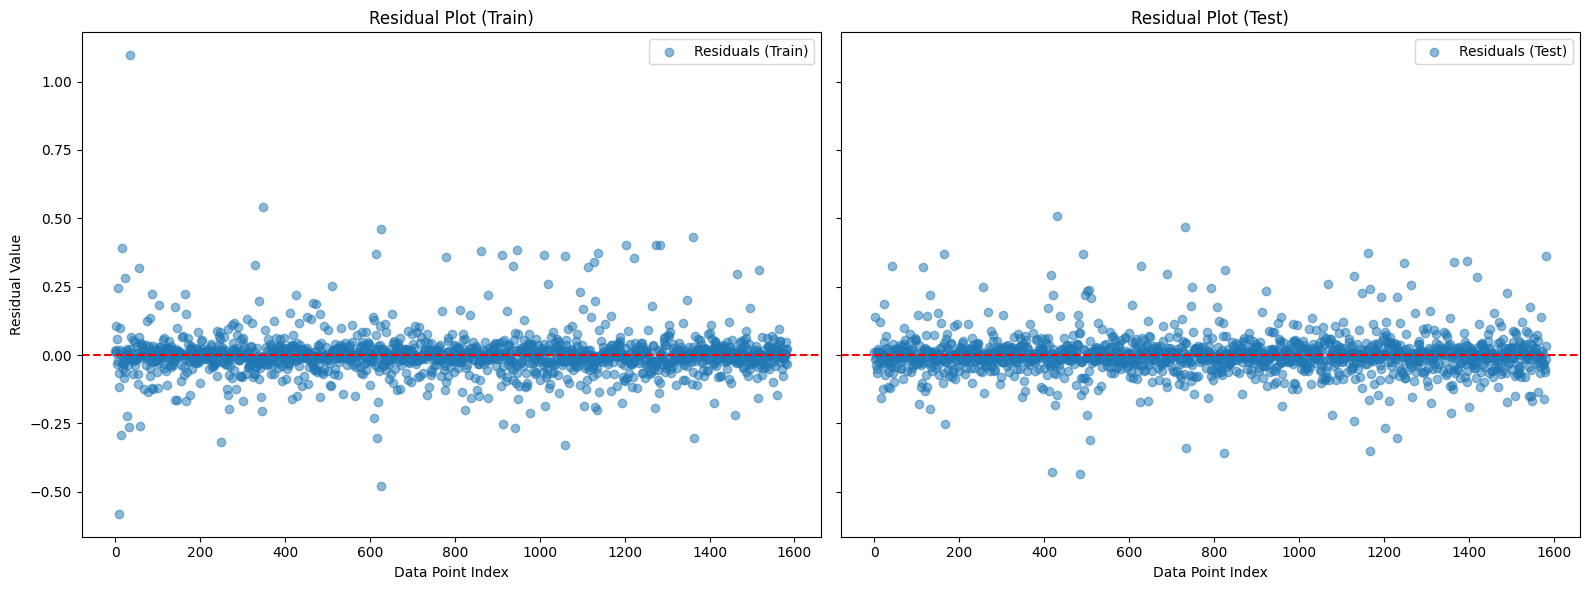

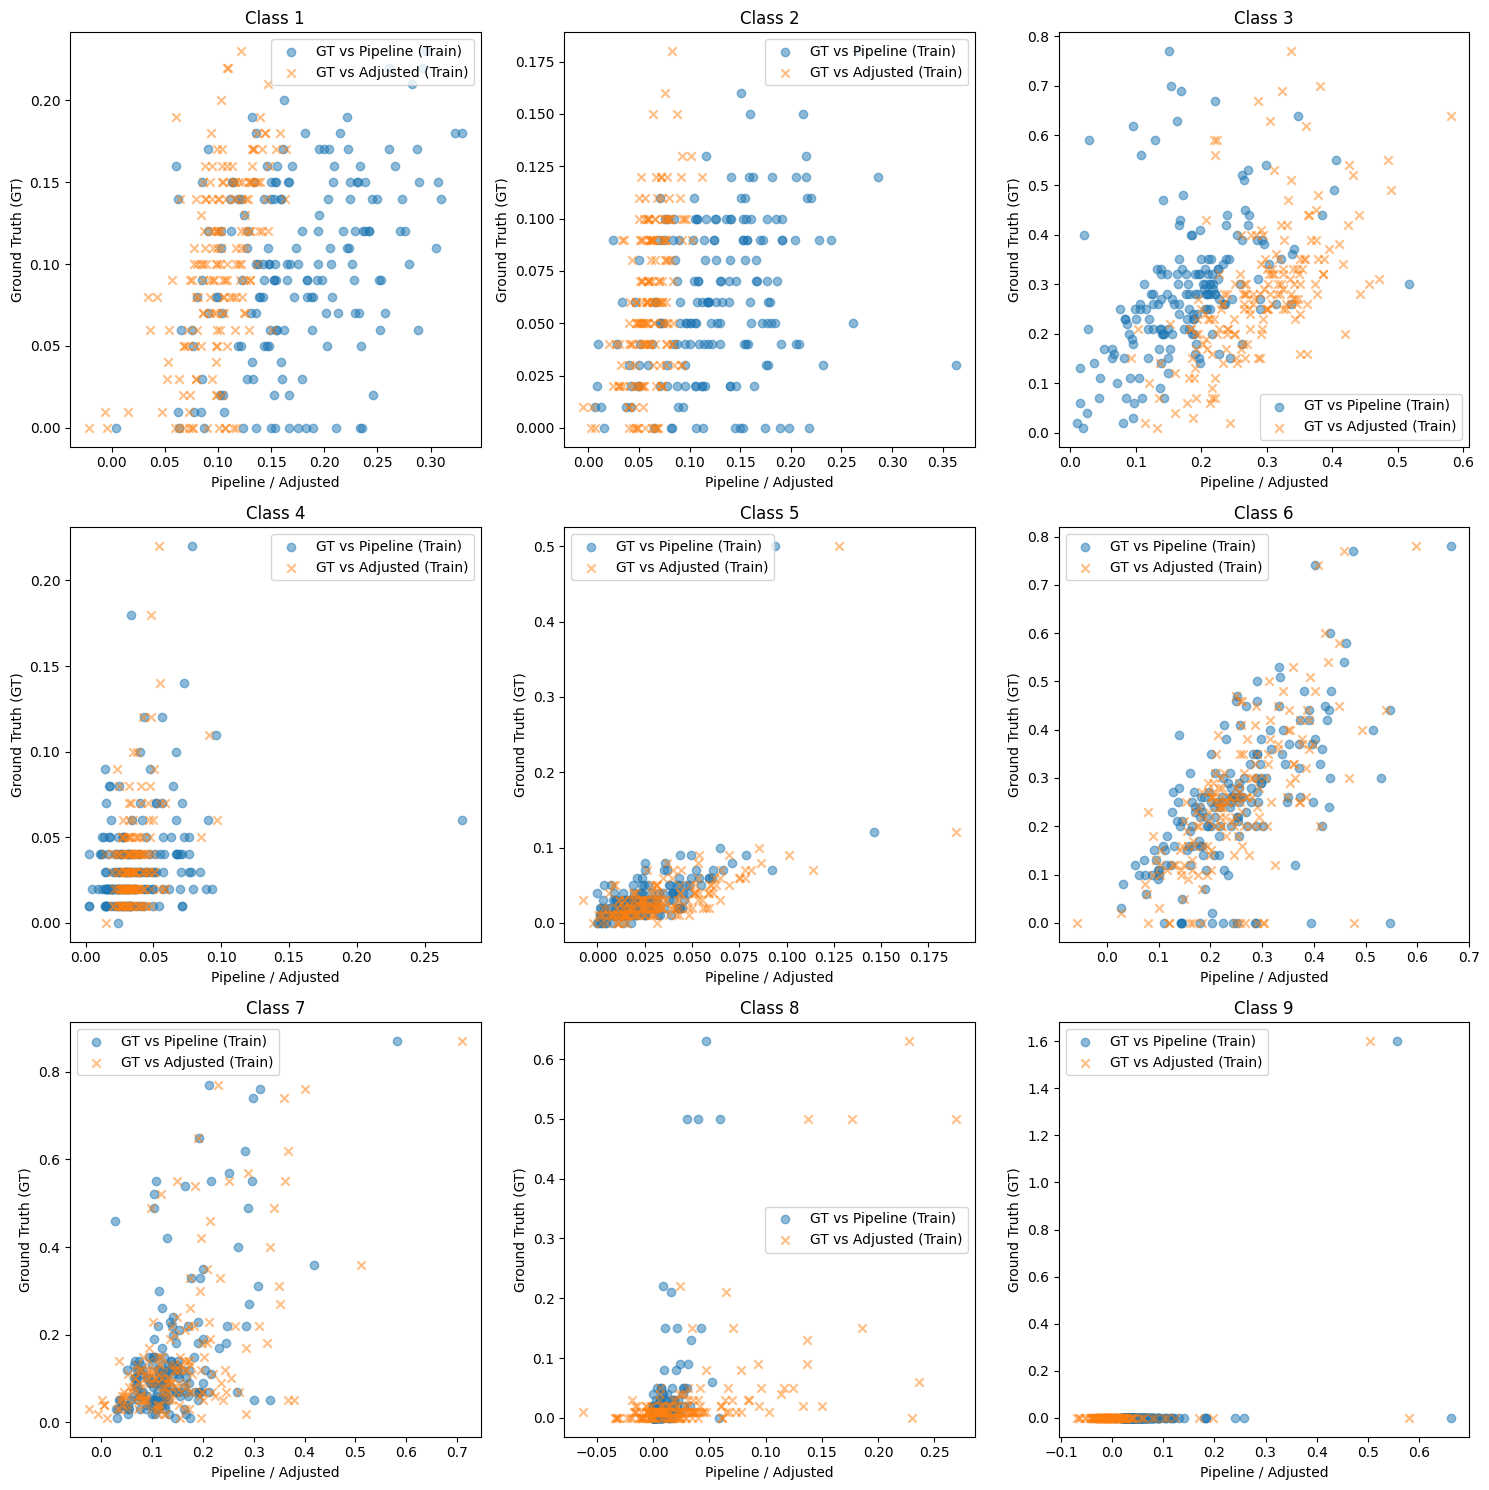

In [21]:
# Residual Plot
# Residuals = Actual (GT) - Predicted (Adjusted)
residuals_train = Y_train - adjusted_train
residuals_test = Y_test - adjusted_test

fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Residual plot for training
ax[0].scatter(np.arange(len(residuals_train.flatten())), residuals_train.flatten(), alpha=0.5, label="Residuals (Train)")
ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_title("Residual Plot (Train)")
ax[0].set_xlabel("Data Point Index")
ax[0].set_ylabel("Residual Value")
ax[0].legend()

# Residual plot for testing
ax[1].scatter(np.arange(len(residuals_test.flatten())), residuals_test.flatten(), alpha=0.5, label="Residuals (Test)")
ax[1].axhline(0, color='red', linestyle='--')
ax[1].set_title("Residual Plot (Test)")
ax[1].set_xlabel("Data Point Index")
ax[1].legend()

plt.tight_layout()
plt.show()

# Pairwise Linearity Assessment
# Scatter plots for each class showing GT vs Pipeline and GT vs Adjusted
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, ax in enumerate(axes.flatten()):
    if i < Y_train.shape[1]:  # Limit to the number of features (classes)
        ax.scatter(X_train[:, i], Y_train[:, i], alpha=0.5, label="GT vs Pipeline (Train)")
        ax.scatter(adjusted_train[:, i], Y_train[:, i], alpha=0.5, label="GT vs Adjusted (Train)", marker='x')
        ax.set_title(f"Class {i + 1}")
        ax.set_xlabel("Pipeline / Adjusted")
        ax.set_ylabel("Ground Truth (GT)")
        ax.legend()

plt.tight_layout()
plt.show()


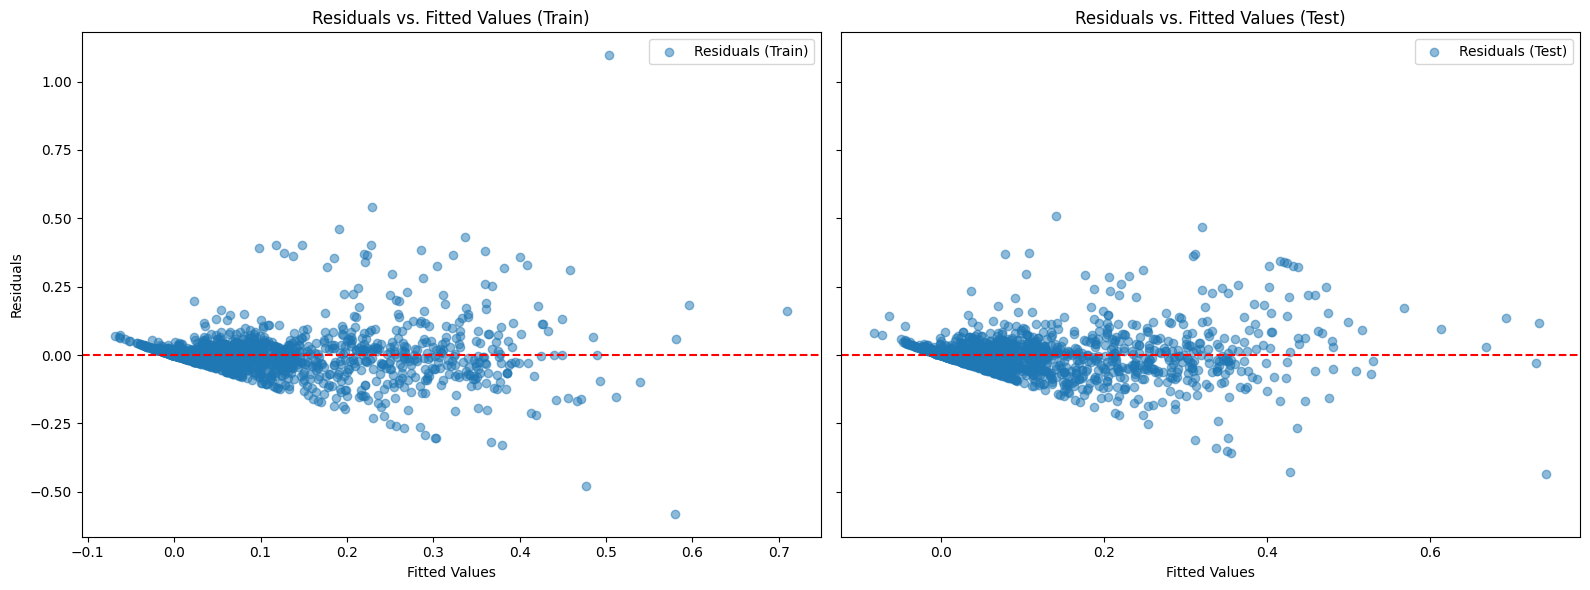

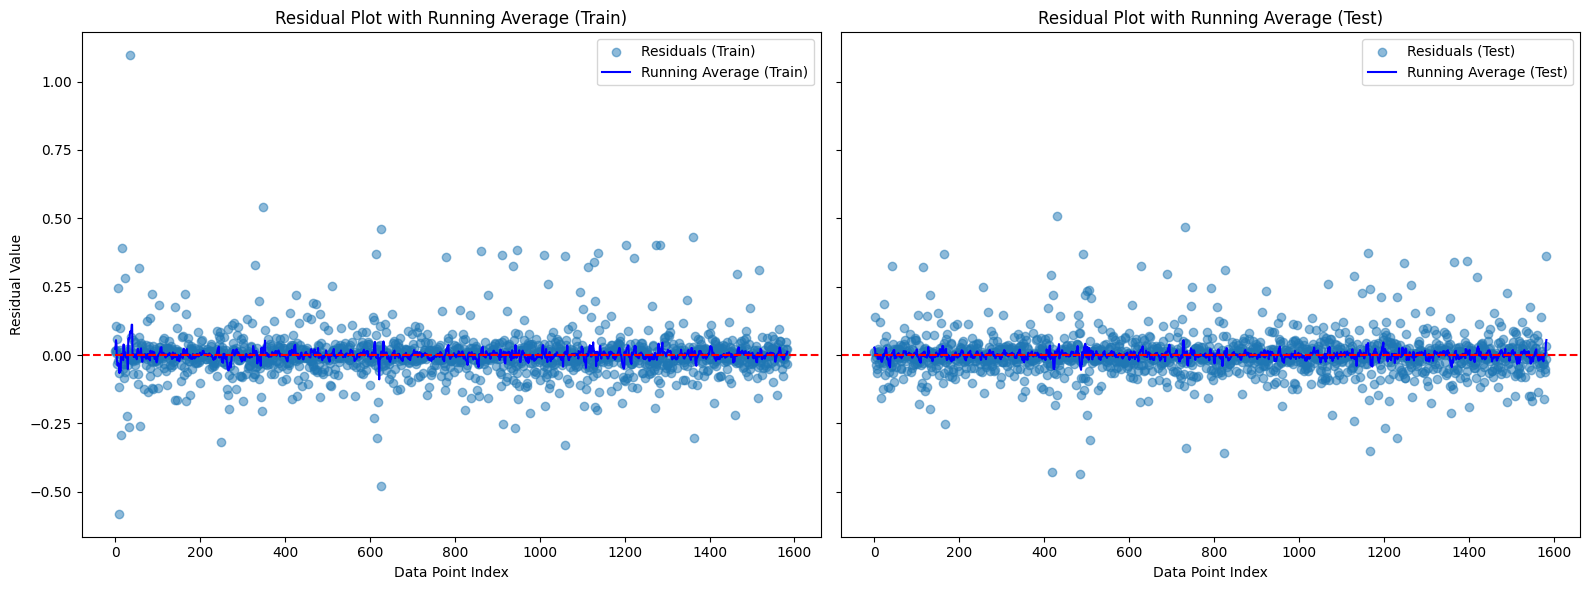

In [22]:
from scipy.ndimage import uniform_filter1d  # For computing the running average

# Residual vs. Fitted Value Plot (for assessing homoscedasticity)
fitted_train = adjusted_train.flatten()
fitted_test = adjusted_test.flatten()

fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Train Residual vs Fitted
ax[0].scatter(fitted_train, residuals_train.flatten(), alpha=0.5, label="Residuals (Train)")
ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_title("Residuals vs. Fitted Values (Train)")
ax[0].set_xlabel("Fitted Values")
ax[0].set_ylabel("Residuals")
ax[0].legend()

# Test Residual vs Fitted
ax[1].scatter(fitted_test, residuals_test.flatten(), alpha=0.5, label="Residuals (Test)")
ax[1].axhline(0, color='red', linestyle='--')
ax[1].set_title("Residuals vs. Fitted Values (Test)")
ax[1].set_xlabel("Fitted Values")
ax[1].legend()

plt.tight_layout()
plt.show()

# Residual Plots with Running Average
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Running average for train
running_avg_train = uniform_filter1d(residuals_train.flatten(), size=10)
ax[0].scatter(np.arange(len(residuals_train.flatten())), residuals_train.flatten(), alpha=0.5, label="Residuals (Train)")
ax[0].plot(np.arange(len(running_avg_train)), running_avg_train, color='blue', label="Running Average (Train)")
ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_title("Residual Plot with Running Average (Train)")
ax[0].set_xlabel("Data Point Index")
ax[0].set_ylabel("Residual Value")
ax[0].legend()

# Running average for test
running_avg_test = uniform_filter1d(residuals_test.flatten(), size=10)
ax[1].scatter(np.arange(len(residuals_test.flatten())), residuals_test.flatten(), alpha=0.5, label="Residuals (Test)")
ax[1].plot(np.arange(len(running_avg_test)), running_avg_test, color='blue', label="Running Average (Test)")
ax[1].axhline(0, color='red', linestyle='--')
ax[1].set_title("Residual Plot with Running Average (Test)")
ax[1].set_xlabel("Data Point Index")
ax[1].legend()

plt.tight_layout()
plt.show()


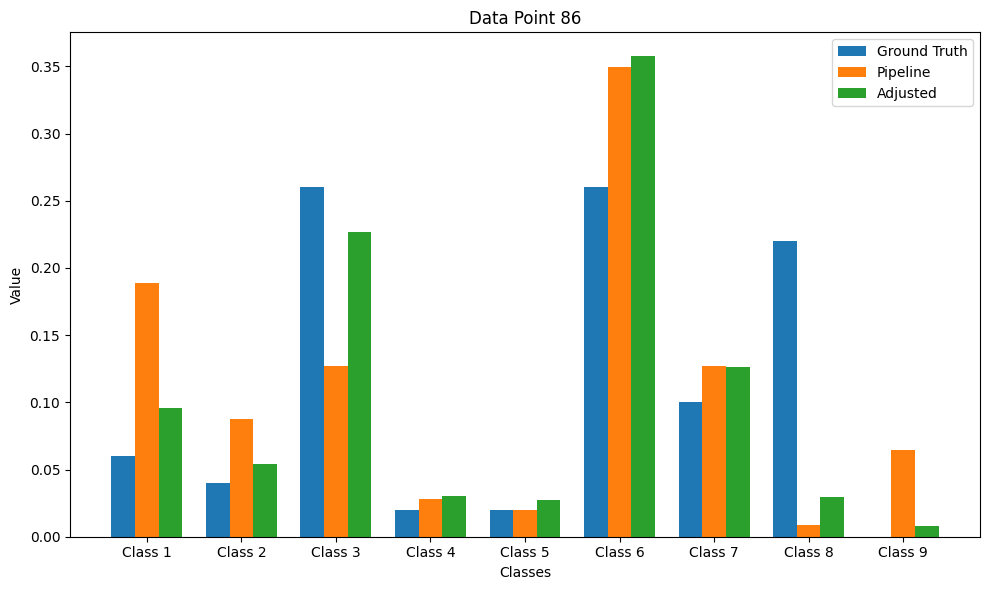

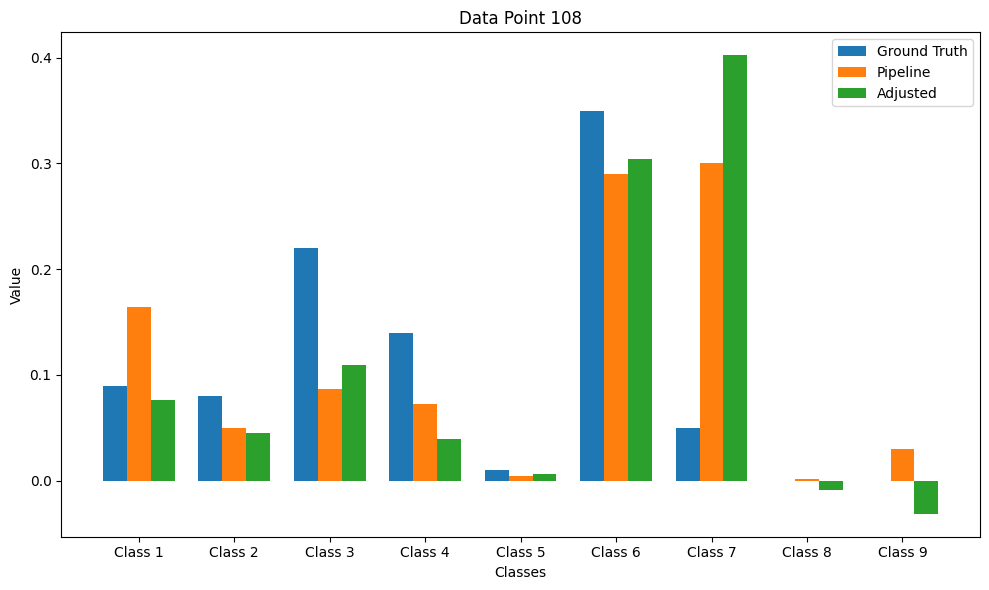

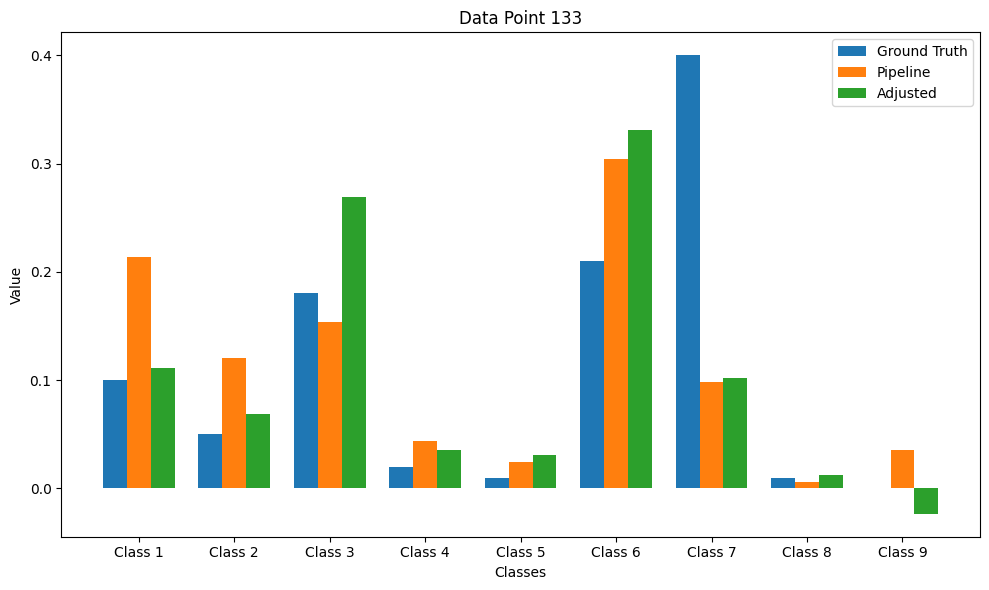

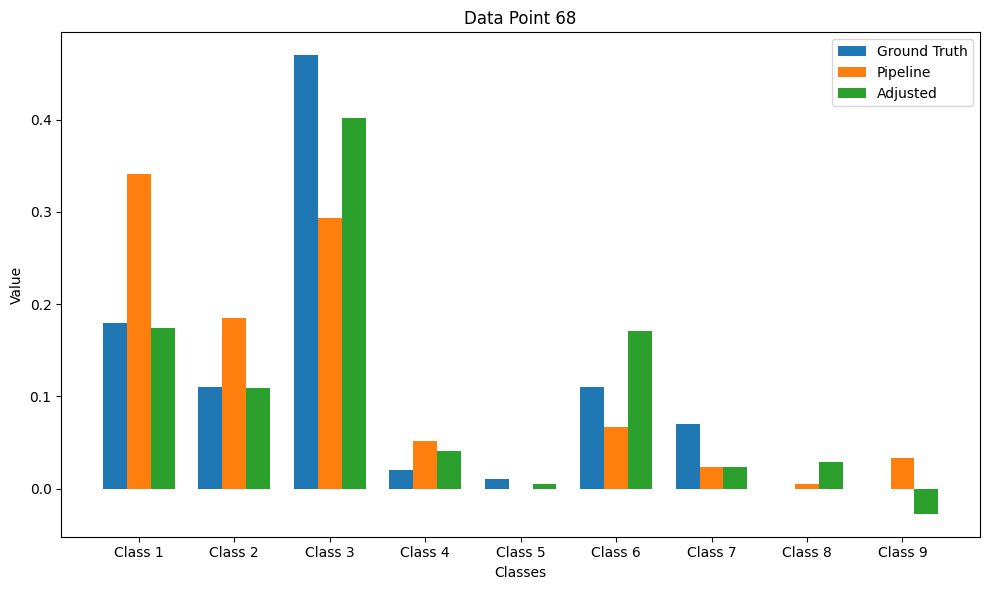

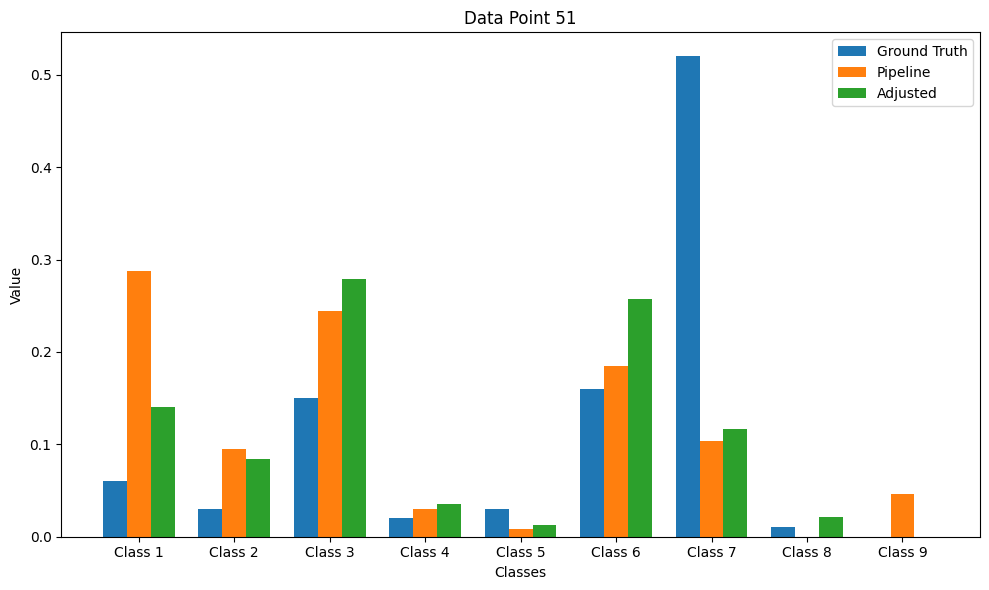

In [24]:
import time  # For delay between plots

# Randomly select 5 data points to display the bar plots
random_indices = np.random.choice(stacked_GT_diff_vectors.shape[0], 5, replace=False)

# Display a plot for each random data point
for idx in random_indices:
    gt = stacked_GT_diff_vectors[idx]
    pipeline = stacked_Pipeline_diff_vectors[idx]
    adjusted = adjusted_diff_vectors[idx]

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width, gt, width, label="Ground Truth")
    ax.bar(x, pipeline, width, label="Pipeline")
    ax.bar(x + width, adjusted, width, label="Adjusted")

    ax.set_title(f"Data Point {idx + 1}")
    ax.set_xlabel("Classes")
    ax.set_ylabel("Value")
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

    # Add a small delay between plots
    time.sleep(2)